In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

import warnings
# filter warnings
warnings.filterwarnings('ignore')

2023-07-17 08:57:52.460587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 08:57:52.834815: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 08:57:52.837044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 08:57:54.098183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_csv = '/home/pierre/Desktop/planet data/planet/planet/train_classes.csv'
test_csv = '/home/pierre/Desktop/planet data/planet/planet/sample_submission.csv'

In [3]:
train_classes = pd.read_csv(train_csv)
train_classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
test_classes= pd.read_csv(test_csv)
test_classes.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [5]:
label_list = [label for tag_str in train_classes.tags.values for label in tag_str.split(' ')]
label_list[:3]

['haze', 'primary', 'agriculture']

In [6]:
from collections import Counter

count_ = Counter(label_list)

count_

defaultdict(int,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

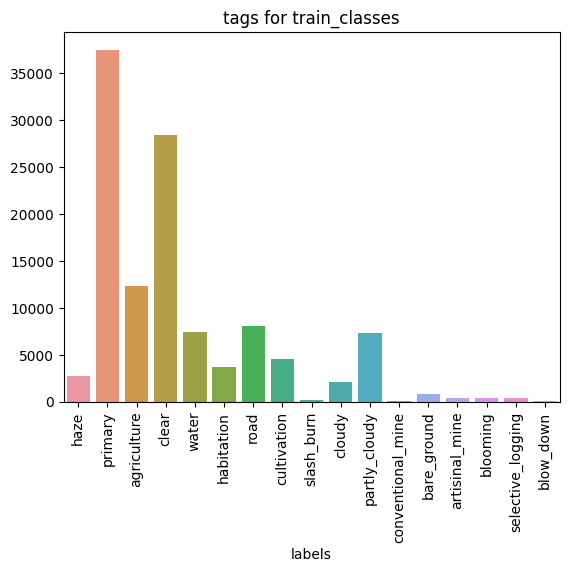

In [7]:
tags = list(count_.keys())
y = list(count_.values())
sns.barplot(x=tags, y=y)
plt.xlabel('labels')
plt.xticks(rotation=90)
plt.title('tags for train_classes')
plt.show()

Text(0.5, 1.0, 'Tag counts for test set')

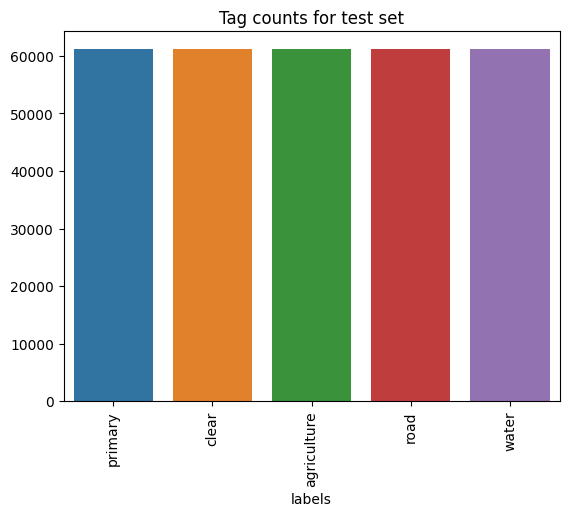

In [8]:
from collections import Counter, defaultdict
test_label = test_classes['tags'].apply(lambda x: x.split(' '))
test_counts = defaultdict(int)
for i in test_label:
for j in i:
test_counts[j] += 1
tag_list_test = list(test_counts.keys())
test_count = list(test_counts.values())
sns.barplot(x=tag_list_test, y=test_count)
plt.xlabel('labels')
plt.xticks(rotation=90)
plt.title('Tag counts for test set')
plt.show()

**The code below helps us to visualize an image for inspection**

In [10]:
class_label = { tag: name for name, tag in enumerate(tags)}
class_label

{'haze': 0,
 'primary': 1,
 'agriculture': 2,
 'clear': 3,
 'water': 4,
 'habitation': 5,
 'road': 6,
 'cultivation': 7,
 'slash_burn': 8,
 'cloudy': 9,
 'partly_cloudy': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

In [11]:
lst = []
for key,value in class_label.items():
    lst.append(key)
lst = np.array(lst)
lst

array(['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation',
       'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy',
       'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
       'selective_logging', 'blow_down'], dtype='<U17')

In [12]:
train_images, train_labels = [],[]
for image_name, tags in tqdm(train_classes.values, miniters=1000):
    arr = cv2.imread('/home/pierre/Desktop/planet data/planet/planet/train-jpg/{}.jpg'.format(image_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[class_label[t]]=1
    train_images.append(cv2.resize(arr,(64,64)))
    train_labels.append(targets) #encodes the labels in target class
    
    

100%|████████████████████████████████████| 40479/40479 [00:57<00:00, 709.96it/s]


In [13]:
test_images = [] 
for image, label in tqdm(test_classes[:40669].values, miniters = 1000):
  path = '/home/pierre/Desktop/planet data/planet/planet/test-jpg/{}.jpg'.format(image)
  test_images.append(cv2.resize(cv2.imread(path), (64,64)))
for image, label in tqdm(test_classes[40669:].values, miniters = 1000):
  path1 = '/home/pierre/Desktop/planet data/test-jpg-additional/test-jpg-additional/{}.jpg'.format(image)
  test_images.append(cv2.resize(cv2.imread(path1), (64,64)))

100%|████████████████████████████████████| 20522/20522 [00:27<00:00, 751.03it/s]


**NORMALIZING TRAIN AND TEST SET**

In [14]:
train_images = np.array(train_images, np.float16)/255.0
train_labels = np.array(train_labels, np.uint8)
test_images = np.array(test_images,np.float16)/255.0

In [15]:
gc.collect()

6483

In [16]:
from sklearn.model_selection import train_test_split, KFold

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.25, shuffle = True, random_state = 0)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    

(30359, 64, 64, 3) (30359, 17) (10120, 64, 64, 3) (10120, 17)


In [17]:
from keras import backend as K
from sklearn.metrics import fbeta_score
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

In [18]:

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


In [19]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop


In [20]:
model = keras.Sequential()  #this model contains two hidden layer, an input and an output layer
model.add(Conv2D(128, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(17, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = [fbeta])
model.fit(x_train, y_train, epochs = 10, batch_size = 128)
val_loss,val_acc = model.evaluate(x_val, y_val)
print('Tested Acc:', val_acc)

Epoch 1/10


2023-07-17 09:00:42.199587: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1492205568 exceeds 10% of free system memory.


238/238 [==============================] - 51s 210ms/step - loss: 0.2606 - fbeta: 0.5947
Epoch 2/10
238/238 [==============================] - 86s 360ms/step - loss: 0.2127 - fbeta: 0.6460
Epoch 3/10
238/238 [==============================] - 66s 278ms/step - loss: 0.2073 - fbeta: 0.6559
Epoch 4/10
238/238 [==============================] - 48s 201ms/step - loss: 0.2040 - fbeta: 0.6620
Epoch 5/10
238/238 [==============================] - 48s 200ms/step - loss: 0.1979 - fbeta: 0.6774
Epoch 6/10
238/238 [==============================] - 46s 194ms/step - loss: 0.1945 - fbeta: 0.6903
Epoch 7/10
238/238 [==============================] - 47s 196ms/step - loss: 0.1925 - fbeta: 0.6957
Epoch 8/10
238/238 [==============================] - 46s 194ms/step - loss: 0.1898 - fbeta: 0.7010
Epoch 9/10
238/238 [==============================] - 48s 200ms/step - loss: 0.1877 - fbeta: 0.7061
Epoch 10/10
238/238 [==============================] - 46s 195ms/step - loss: 0.1860 - fbeta: 0.7101


2023-07-17 09:09:36.185801: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 497418240 exceeds 10% of free system memory.


317/317 [==============================] - 4s 13ms/step - loss: 0.1873 - fbeta: 0.7183
Tested Acc: 0.7183013558387756


In [21]:
from keras.applications.vgg16 import VGG16

In [22]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [23]:
import tensorflow_addons as tfa

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16

optimizer = Adam(learning_rate=0.003)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model, Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(17, activation='sigmoid')
])

# Define the fbeta metric
fbeta = tfa.metrics.FBetaScore(num_classes=17, average='micro', threshold=None)

# Compile the model with the fbeta metric
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[fbeta])

model.fit(x_train, y_train, epochs=10, batch_size=128)
val_loss, val_fbeta = model.evaluate(x_val, y_val)
print('Tested Acc:', val_fbeta)

/home/pierre/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-07-17 09:09:49.989807: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1492205568 exceeds 10% of free system memory.


Epoch 1/10
238/238 [==============================] - 630s 3s/step - loss: 0.1955 - fbeta_score: 0.4805
Epoch 2/10
238/238 [==============================] - 606s 3s/step - loss: 0.1567 - fbeta_score: 0.4906
Epoch 3/10
238/238 [==============================] - 608s 3s/step - loss: 0.1495 - fbeta_score: 0.4923
Epoch 4/10
238/238 [==============================] - 607s 3s/step - loss: 0.1449 - fbeta_score: 0.4943
Epoch 5/10
238/238 [==============================] - 605s 3s/step - loss: 0.1429 - fbeta_score: 0.4939
Epoch 6/10
238/238 [==============================] - 601s 3s/step - loss: 0.1398 - fbeta_score: 0.4950
Epoch 7/10
238/238 [==============================] - 603s 3s/step - loss: 0.1385 - fbeta_score: 0.4955
Epoch 8/10
238/238 [==============================] - 602s 3s/step - loss: 0.1380 - fbeta_score: 0.4957
Epoch 9/10
238/238 [==============================] - 603s 3s/step - loss: 0.1365 - fbeta_score: 0.4957
Epoch 10/10
238/238 [==============================] - 640s 3s/s

2023-07-17 10:51:39.672729: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 497418240 exceeds 10% of free system memory.


317/317 [==============================] - 217s 685ms/step - loss: 0.1353 - fbeta_score: 0.4970
Tested Acc: 0.4970305562019348


In [24]:
gc.collect()

6134

In [25]:
predictions = model.predict(test_images, batch_size = 128)
result_list = []
result_list.append(predictions)

2023-07-17 10:55:30.071803: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3007660032 exceeds 10% of free system memory.


479/479 [==============================] - 1387s 3s/step


In [26]:
answer = np.array(result_list[0])
for i in range(1,len(result_list)):
    answer += np.array(result_list[i])
answer = pd.DataFrame(answer, columns = lst)
answer.head()

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,0.083768,0.999631,0.032151,0.851917,0.030935,0.002313,0.013354,0.009447,0.000013,4.432827e-05,0.024217,4.912417e-07,0.001113,3.731579e-07,0.006076,0.001516,0.000286
1,0.001762,0.999944,0.081109,0.993134,0.115528,0.008249,0.089195,0.061489,0.000540,1.581879e-07,0.005042,5.963665e-06,0.004856,1.207417e-05,0.064765,0.066715,0.006097
2,0.000017,0.999509,0.056287,0.000052,0.049858,0.000491,0.012106,0.006906,0.000021,5.883505e-04,0.999432,3.399230e-07,0.000138,5.738993e-06,0.000018,0.000086,0.000022
3,0.001431,0.999949,0.051089,0.983129,0.023714,0.002378,0.012880,0.027884,0.000201,9.229833e-07,0.019685,4.473802e-06,0.003102,6.752558e-06,0.023877,0.008797,0.004196
4,0.014277,0.683254,0.236926,0.020189,0.213123,0.012974,0.106148,0.029831,0.000171,3.185273e-01,0.623451,4.609483e-04,0.013294,1.150536e-03,0.000083,0.000138,0.000105


In [27]:
pred_ = []
for i in tqdm(range(answer.shape[0]),miniters = 1000):
    a = answer.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis = 1)
    a = a.transpose()
    a = a.loc[a[i]== True]
    ' '.join(list(a.index))
    pred_.append(' '.join(list(a.index)))

100%|████████████████████████████████████| 61191/61191 [01:25<00:00, 716.12it/s]


In [28]:
test_classes['tags'] = pred_
test_classes.to_csv('Submission.csv', index = False)